In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
f = r.TFile("./weird_islands_calo11_xtal18.root")
t = f.Get("fitDisplay1/fits/fitTree")
t.Print()

******************************************************************************
*Tree    :fitTree   : fitTree                                                *
*Entries :    18724 : Total =         7811933 bytes  File  Size =    3361149 *
*        :          : Tree compression factor =   2.32                       *
******************************************************************************
*Br    0 :caloNum   : caloNum/I                                              *
*Entries :    18724 : Total  Size=      75620 bytes  File Size  =        703 *
*Baskets :        3 : Basket Size=      32000 bytes  Compression= 106.87     *
*............................................................................*
*Br    1 :xtalNum   : xtalNum/I                                              *
*Entries :    18724 : Total  Size=      75620 bytes  File Size  =       1289 *
*Baskets :        3 : Basket Size=      32000 bytes  Compression=  58.28     *
*...................................................

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0}


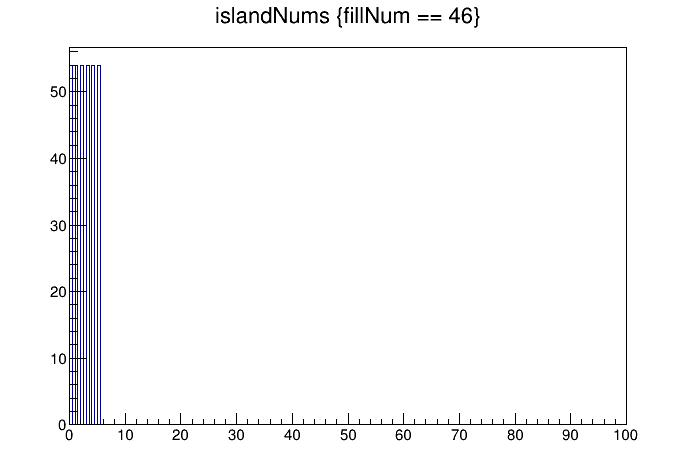

In [3]:
c = r.TCanvas()
events = t.Draw("islandNums>>hist(200,0,100)","fillNum == 46")
print(set([t.GetV1()[i] for i in range(events)]))
c.Draw()

In [4]:
def returnXtalIslands(f, folderName, calo, xtal, fillNum, island):
    '''
        Function to plot the calo islands stored in tree t.
        Inputs: file containing data, folder name which has the tree/spline, calo, xtal, fill, island
        Outputs: canvas, histograms in vector
    '''
    t = f.Get(folderName+"/fits/fitTree")
    
    cutString = ("caloNum == "+str(calo)
              +" && xtalNum == "+str(xtal)
              +" && fillNum == "+str(fillNum)
              #+" && chi2 < 100"
            )    
    
    t.Draw("subRunNum",cutString,"goff")
    subrun = int(t.GetV1()[0])
    #print("Subrun", subrun)
    n_entries = t.BuildIndex('fillNum*(subRunNum=={})'.format(subrun),
                             'islandNums[0]*(xtalNum == 0 && subRunNum == {}) - 1*(xtalNum!=0)'.format(subrun))
    
    
    entries = []
    islandNums = [island]
    #print(islandNums)
    for island in islandNums:
        entry_num = t.GetEntryNumberWithIndex(fillNum, island) 
        #print(island, entry_num)
        if(entry_num > -0.01):
            entries.append(entry_num + xtal)
    #print(entries)
    
    if(len(entries) < 1):
        print("Error: This island does not exist")
        return 0
    
    islandLengths = []
    energies = []
    pedestals = []
    islandNums = []
    chiSquare = []
    statuses = []
    laserHits = []
    times = []
    firstSamples = []
    traces = []
    graphs = []

    for entry in entries:
        t.GetEntry(entry)

        islandLengths.append(t.islandLengths[0])
        energies.append([x for x in t.energies])
        pedestals.append(t.pedestal)
        islandNums.append(t.islandNums[0])
        chiSquare.append(t.chi2)
        statuses.append([x for x in t.statuses])
        laserHits.append([x for x in t.laserHits])
        times.append([x for x in t.times])
        firstSamples.append(t.firstSampleNums[0])
        traces.append( [x for x in t.trace] )

    ding = {"lenghts":islandLengths, 
            "energies":energies, 
            "pedestals":pedestals, 
            "islandNums":islandNums, 
            "chiSquare":chiSquare, 
            "statuses":statuses, 
            "laserHits":laserHits, 
            "times":times, 
            "firstSamples":firstSamples, 
            "traces":traces}
    for i, trace in enumerate(traces):
        gri = r.TGraph()
        for j, ti in enumerate(trace):
            gri.SetPoint(j, j, ti)
        gri.SetMarkerSize(0.6)
        gri.SetMarkerStyle(8)
        gri.SetTitle("Trace: Calo "+str(calo)+", Xtal "+str(xtal)+" in Fill "+str(fillNum)+", Island "+str(islandNums[i])
                     +"; Sample Number; Amplitude [ADC Units]")
        graphs.append(gri)
    #print(graphs)

    spline = f.Get(folderName).Get("splines").Get("laser"+str(xtal))
    beamspline = f.Get(folderName).Get("splines").Get("beam"+str(xtal))
    #print(spline)
    
    whichGraph = 0
    splineGraphs = []
    for whichGraph in range(len(traces)):

        splineGraphsi = []
        allSplineScaled = []

        for fiti in range(len(times[whichGraph])):
            splineScaled = []
            offset = times[whichGraph][fiti] - firstSamples[whichGraph]
            #print(offset)
            for i in range(len(traces[whichGraph])):
                splineScaled.append( spline.Eval(i - offset)*energies[whichGraph][fiti] + pedestals[whichGraph] )
            #print(splineScaled)
            allSplineScaled.append(splineScaled)

            splineGraph = r.TGraph()
            for i, si in enumerate(splineScaled):
                splineGraph.SetPoint(i, i, si)
            splineGraph.SetLineColor(fiti+2)
            splineGraphsi.append(splineGraph)

        if( len(times[whichGraph]) > 1):
            splineGraph = r.TGraph()
            totalSpline = [pedestals[whichGraph] for x in range(len(allSplineScaled[0]))]
            for i, si in enumerate(allSplineScaled):
                for ii, sii in enumerate(si):
                    totalSpline[ii] += sii - pedestals[whichGraph]

            for i, si in enumerate(totalSpline):
                splineGraph.SetPoint(i, i, si )

            splineGraph.SetLineColor(9)
            splineGraphsi.append(splineGraph)

        splineGraphs.append(splineGraphsi)
        
        
    textBoxes = []
    for i in range(len(traces)):
        pt = r.TPaveText(0.45,0.45,0.87,0.87,"ndc");
        for j in range(len(energies[i])):
            pt.AddText("E_{0} = "+str(round(energies[i][j],2)))
            pt.AddText("t_{0} = "+str(round(times[i][j],2)))
            pt.AddText("Pedestal = "+str(pedestals[i]))
            pt.AddText("Status = "+str(statuses[i]))
            pt.AddText("Laser Hit = "+str(laserHits[i][j]))
            pt.AddText("#chi^{2} = "+str(round(chiSquare[i],2)))
            pt.AddText(" ")
            pt.AddLine()

        textBoxes.append(pt)
    #print(textBoxes)
    
    if(len(traces) > 1):
        c = r.TCanvas("c","c", int(np.ceil((len(traces)/2)))*600, 2*600)
        c.Divide(int(np.ceil((len(traces)/2))), 2)
        for i in range(len(traces)):
            c.cd(i+1)
            graphs[i].Draw("ap")
            for si in splineGraphs[i]:
                si.Draw("l same")
            textBoxes[i].Draw("SAME")
    else:
        c = r.TCanvas("c","c", 1200,600)
        for i in range(len(traces)):
            graphs[i].Draw("ap")
            for si in splineGraphs[i]:
                si.Draw("l same")
            textBoxes[i].Draw("SAME")

    c.Draw()
    return {"canvas":c, "graphs":graphs, "text":textBoxes, "splines":splineGraphs, "rawinfo":ding}
    

[[2134.8095847533937, 5001.434764855458, 1140.7950186686874, 1102.8830335649275, 1793.2191140339498]]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


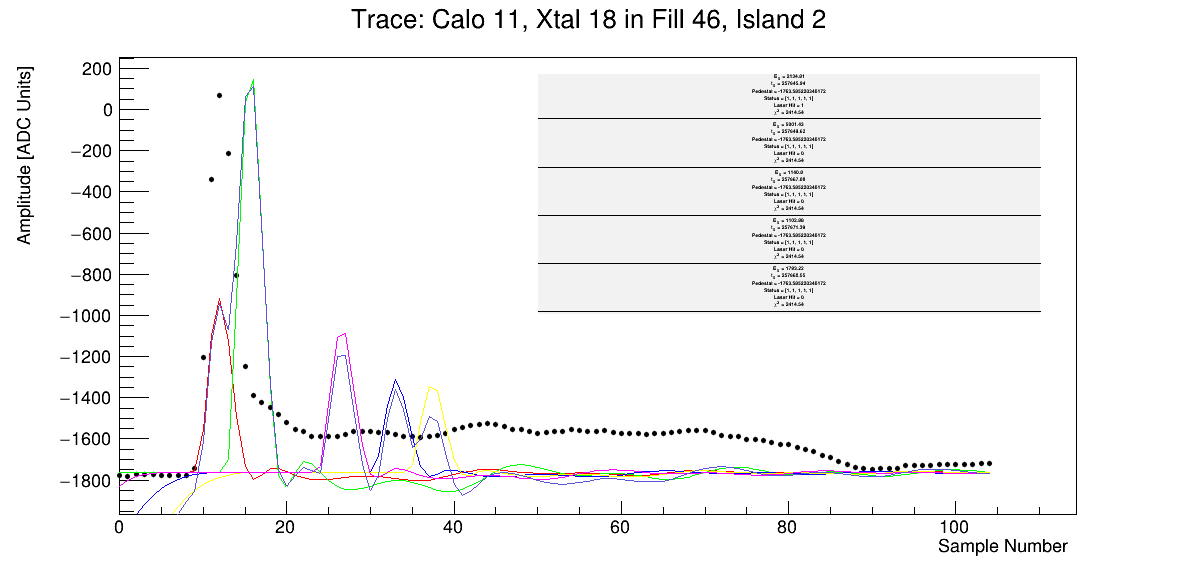

In [12]:
plots = returnXtalIslands(f, "fitDisplay1", 11, 18, 46, 2)
print(plots['rawinfo']['energies'])

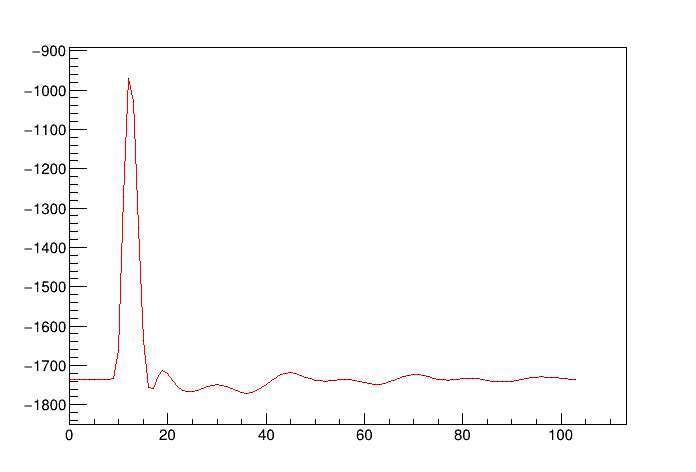

In [6]:
c = r.TCanvas()
plots['splines'][0][0].Draw()
c.Draw()